We would like to check the claim that when you compute the empirical NTK for a vector output, it factorizes into a common kernel for all outputs.
We will check this empirically on MNIST.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# %%

#loading MNIST
train_data = dsets.MNIST(root = '/Users/aaronhillman/Desktop/data', train = True,transform = transforms.ToTensor(),
                   download = True)
test_data = dsets.MNIST(root = '/Users/aaronhillman/Deskstop/data', train = False,transform = transforms.ToTensor(),
                   download = True)

#Flatten
Xtr = torch.stack([x[0].view((28*28,)) for x in train_data])
Ytr = torch.tensor([x[1] for x in train_data])

#### First define the MLP that will compute MNIST digit predictions.

In [3]:
#setup the model
class MLP(nn.Module):

    def __init__(self, width):
        super().__init__()
        self.width = width
        self.net = nn.Sequential( nn.Linear(28*28, width), nn.ReLU(), nn.Linear(width, 10))

    

    def forward(self, x_batch, y_batch = None):
        x_out = self.net(x_batch)
        x_out = x_out/np.sqrt(28*self.width)
        if y_batch is None:
            loss = None
        else:
            #now compute the mean-squared error loss
            loss = F.mse_loss(x_out, y_batch)
            
        return x_out, loss

m = MLP(1000)

In [4]:

# Function to compute the NTK matrix
def compute_ntk(model, x_batch):
    # Forward pass
    x_out, _ = model(x_batch)
    
    # Initialize the NTK matrix
    ntk_matrix = torch.zeros(x_out.size(1), x_out.size(1), x_batch.size(0), x_batch.size(0))
    
    # Compute gradients of the outputs with respect to the parameters
    for i in range(x_batch.size(0)):
        for k in range(x_out.size(1)):
            model.zero_grad()
            x_out[i, k].backward(retain_graph=True)
            
            # Flatten the gradients into a single vector
            grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
            
            # Compute the NTK entries
            for j in range(x_batch.size(0)):
                for l in range(x_out.size(1)):
                    model.zero_grad()
                    x_out[j, l].backward(retain_graph=True)
                    grads_j = torch.cat([param.grad.view(-1) for param in model.parameters()])
                    ntk_matrix[k, l, i, j] = torch.dot(grads, grads_j)
    
    return ntk_matrix
 # Should print torch.Size([10, 10, 32, 32])

First we check for gaussian inputs.

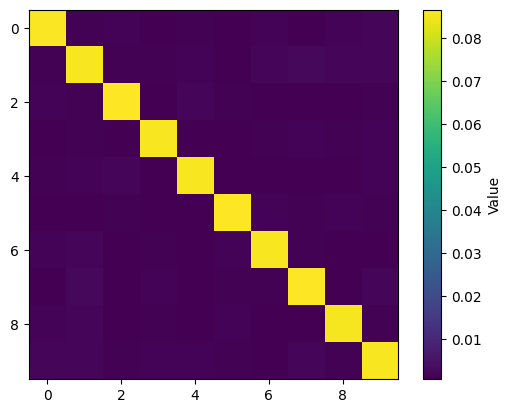

In [5]:
# Example usage
x_batch = torch.randn(32, 28*28)  # Example batch of inputs
ntk_matrix = compute_ntk(m, x_batch)
plt.imshow([[torch.linalg.matrix_norm(ntk_matrix[i, j], ord='fro').item() for i in range(10)] for j in range(10)])
plt.colorbar(label='Value')
plt.show()


Now let's see if they are truly factorized, i.e. the diagonal matrices are approximately the same.

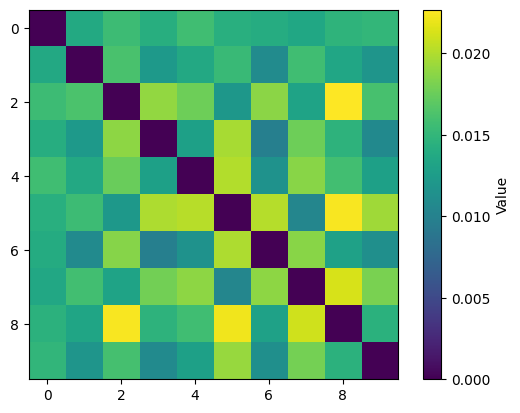

In [7]:
plt.imshow([[torch.linalg.matrix_norm(ntk_matrix[i, i]-ntk_matrix[j, j], ord='fro').item()/torch.linalg.matrix_norm(ntk_matrix[i, i], ord='fro') for i in range(10)] for j in range(10)])
plt.colorbar(label='Value')
plt.show()

We see that the kernel does approximately factorize.

#### Now on MNIST inputs

Now we will simply 

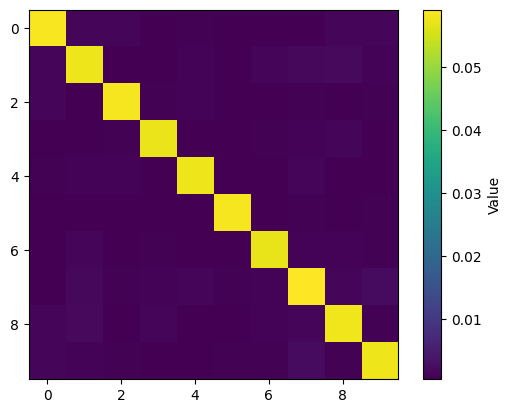

In [11]:
# Example usage
x_batch = Xtr[:100]  # Example batch of inputs
ntk_matrix = compute_ntk(m, x_batch)
plt.imshow([[torch.linalg.matrix_norm(ntk_matrix[i, j], ord='fro').item() for i in range(10)] for j in range(10)])
plt.colorbar(label='Value')
plt.show()


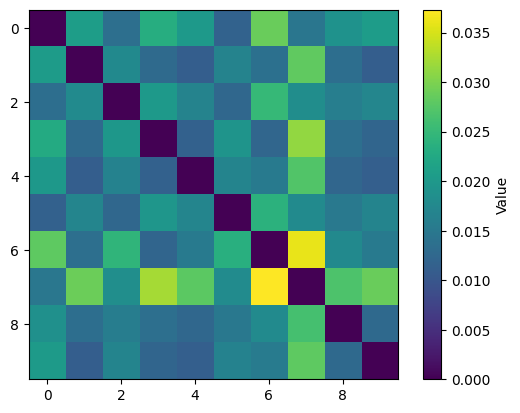

In [12]:
plt.imshow([[torch.linalg.matrix_norm(ntk_matrix[i, i]-ntk_matrix[j, j], ord='fro').item()/torch.linalg.matrix_norm(ntk_matrix[i, i], ord='fro') for i in range(10)] for j in range(10)])
plt.colorbar(label='Value')
plt.show()

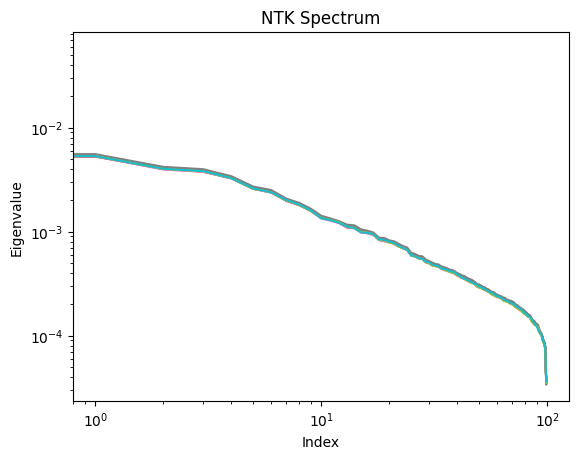

In [19]:
specs = [sorted(np.linalg.eigvalsh(ntk_matrix[i, i]), reverse = True) for i in range(10)]
for spec in specs:
    plt.loglog(spec)

plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('NTK Spectrum')

plt.show()